In [1]:
import pandas as pd
import bioframe
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from matplotlib.colors import LogNorm, Normalize
# https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self, vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.array(np.interp(np.log(value), x, y), mask=result.mask, copy=False)

In [3]:
# import standard python libraries
import seaborn as sns
# import libraries for biological data analysis
from coolpuppy import coolpup as cp
import cooler
import bioframe
# only to get the "fall" colormap ...
import cooltools.lib.plotting
from matplotlib import colors

In [4]:
import scipy
from cooltools import expected_cis
from mpire import WorkerPool

# plot pileup ...

def plot_cpup(hm_plus, flip45=True ):
    """
    extract cpup pileup from that huge dictionary for a given sample (exp,size)
    and also flip45 if requested ...
    """
    # hm_plus = df.loc[0,"data"]
    hm_average = hm_plus
    if not flip45:
        return hm_average
    else:
        _hm = scipy.ndimage.rotate(hm_average,45,cval=np.nan,reshape=True)
        l,w = _hm.shape
        half_l = l//2
        # removing upper pic spitz vershina "verh == up"
        pic_hide = int(0.33*half_l)
        return _hm[pic_hide:half_l,:]

def check_spacedout(l):
    x = np.array(l, dtype=int)
    # make sure relevant exons are spaced out enough ...
    return np.diff(np.sort(x)).min()


In [10]:
def get_gene_pup(
    sites,
    clr,
    resolution,
    _cols=["chrom","start","end", "strand"],
    _flip_strand=True,
    _nproc=16
):
    """
    generate scaled local pile-up for a collection of sites for a given
    cooler (clr) at a given resolution - keeping the padding size equal
    to the interval itself.
    """
    _sites = sites[_cols] \
        .reset_index(drop=True) \
        .rename( dict(zip(_cols,["chrom","start","end","strand"])), axis=1 )
    # create coords - for rescaled genes ...
    cc = cp.CoordCreator(
        _sites,
        resolution=resolution,
        features_format='bed',
        local=True,
        rescale_flank=1.
    )
    # create pileupper object ...
    pu = cp.PileUpper(
        clr,
        cc,
        control = True,
        rescale = True,
        rescale_size = 199,
        flip_negative_strand=_flip_strand,
    )
    print(f"working on a group of {len(_sites)} size ...")
    # pileupsWithControl
    # pileupsByStrandWithControl
    pup = pu.pileupsWithControl(nproc=_nproc)
    # return pup.loc[0,"data"]
    return pup.set_index("group").loc["all","data"]


def get_3way_gene(df):
    """
    given exonStarts and exonEnds yield 4 BEDframes corresponding to alternative transcription variants ...
    """
    df_upup = df.copy()
    df_downdown = df.copy()
    df_updown = df.copy()  # full gene body

    _0 = df["exonStarts"].str.split(",").str[0].astype(int).to_numpy()
    _1 = df["exonStarts"].str.split(",").str[1].astype(int).to_numpy()
    _2 = df["exonStarts"].str.split(",").str[2].astype(int).to_numpy()
    _3 = df["exonStarts"].str.split(",").str[3].astype(int).to_numpy()
    
    # needed for the "-" transcripts ...
    _0e = df["exonEnds"].str.split(",").str[0].astype(int).to_numpy()
    _1e = df["exonEnds"].str.split(",").str[1].astype(int).to_numpy()
    _2e = df["exonEnds"].str.split(",").str[2].astype(int).to_numpy()
    _3e = df["exonEnds"].str.split(",").str[3].astype(int).to_numpy()
    
    # following is true for "+" strand :
    # TSSs
    df_upup["start"] = _0
    df_downdown["start"] = _1
    df_updown["start"] = _0
    # TESs
    df_upup["end"] = _2
    df_downdown["end"] = _3
    df_updown["end"] = _3

    # now goes "-":
    _plus_strand = df.eval("strand=='+'")
    # upstream - kinda the "main" one
    df_upup["start"] = df_upup["start"].where(_plus_strand, other=_2e)  # upstream TES
    df_upup["end"] = df_upup["end"].where(_plus_strand, other=_0e)  # upstream TSS (gene's start)

    # up - down combo ....
    df_updown["start"] = df_updown["start"].where(_plus_strand, other=_3e)  # downstream TES (gene's end)
    df_updown["end"] = df_updown["end"].where(_plus_strand, other=_0e)  # upstream TSS (gene's start)

    # downstream - the "secondary" one - one that starts downstream ...
    df_downdown["start"] = df_downdown["start"].where(_plus_strand, other=_3e)  # downstream TES (gene's end)
    df_downdown["end"] = df_downdown["end"].where(_plus_strand, other=_1e)  # downstream TSS
 
    df_upup["size"] = df_upup.eval("end - start")
    df_downdown["size"] = df_downdown.eval("end - start")
    df_updown["size"] = df_updown.eval("end - start")

    assert (df_upup["size"]>0).all()
    assert (df_downdown["size"]>0).all()
    assert (df_updown["size"]>0).all()

    return df_upup, df_downdown, df_updown



def get_homo_combo(df):
    """
    given exonStarts and exonEnds yield 2 BEDframes corresponding combination of TSSs and a combo of TESs ...
    """
    df_tss = df.copy()
    df_tes = df.copy()

    _0 = df["exonStarts"].str.split(",").str[0].astype(int).to_numpy()
    _1 = df["exonStarts"].str.split(",").str[1].astype(int).to_numpy()
    _2 = df["exonStarts"].str.split(",").str[2].astype(int).to_numpy()
    _3 = df["exonStarts"].str.split(",").str[3].astype(int).to_numpy()
    
    # needed for the "-" transcripts ...
    _0e = df["exonEnds"].str.split(",").str[0].astype(int).to_numpy()
    _1e = df["exonEnds"].str.split(",").str[1].astype(int).to_numpy()
    _2e = df["exonEnds"].str.split(",").str[2].astype(int).to_numpy()
    _3e = df["exonEnds"].str.split(",").str[3].astype(int).to_numpy()


    
    # following is true for "+" strand :
    # TSSs
    df_tss["start"] = _0
    df_tss["end"] = _1
    # TESs
    df_tes["start"] = _2
    df_tes["end"] = _3

    # now goes "-":
    _plus_strand = df.eval("strand=='+'")
    # combination of TSSs
    df_tss["end"] = df_tss["end"].where(_plus_strand, other=_0e)  # upstream TSS (gene's start)
    df_tss["start"] = df_tss["start"].where(_plus_strand, other=_1e)  # downstream TSS
    # combination of TESs
    df_tes["end"] = df_tes["end"].where(_plus_strand, other=_2e)  # upstream TES
    df_tes["start"] = df_tes["start"].where(_plus_strand, other=_3e)  # downstream TES (gene's end)
 
    df_tss["size"] = df_tss.eval("end - start")
    df_tes["size"] = df_tes.eval("end - start")

    assert (df_tss["size"]>0).all()
    assert (df_tes["size"]>0).all()

    return df_tss, df_tes



## Latest files with the genes ...

```sh

# H1 ESC ...
./latest_from_ezequiel/control_H1_nofilter.tsv
./latest_from_ezequiel/MaPITA_H1_nofilter.tsv

# HFFc6 ...
./latest_from_ezequiel/control_HHFFc6_nofilter.tsv
./latest_from_ezequiel/MaPITA_HHFFc6_nofilter.tsv
```

In [11]:
! ls ./latest_from_ezequiel/

 20231026_R2-100vsR2-50.pptx
 41592_2021_1248_MOESM3_ESM.xlsx
'APPLE SPECS.pdf'
 control_H1_nofilter.tsv
 control_H1_nofilter_withusage.tsv
 control_HHFFc6_nofilter.tsv
 control_HHFFc6_nofilter_withusage.tsv
 DNase-List.txt.gz
'Figure5_inprogress (1).pdf'
 Figure5_inprogress_new.pdf
 Figure5_inprogress.pdf
'Files with usage information.zip'
 H1_nofilter_altTSS_uniquepolyA.tsv
 HHFFc6_nofilter_altTSS_uniquepolyA.tsv
 MaPITA_H1_nofilter.tsv
 MaPITA_H1_nofilter_withusage.tsv
 MaPITA_HHFFc6_nofilter.tsv
 MaPITA_HHFFc6_nofilter_withusage.tsv
 Resume_CleisBattaglia.pdf
 s41594-022-00890-9.pdf
 TSS.Basic.bed.gz
'UMass Chan Cares -- UMass Chan Medical School Charitable Giving.pdf'


In [12]:
genes_fnames = {
    "ctrl_esc": "./latest_from_ezequiel/control_H1_nofilter.tsv",
    "pita_esc": "./latest_from_ezequiel/MaPITA_H1_nofilter.tsv",
    "ctrl_hff": "./latest_from_ezequiel/control_HHFFc6_nofilter.tsv",
    "pita_hff": "./latest_from_ezequiel/MaPITA_HHFFc6_nofilter.tsv",
}

# # Original filtered lists ...
# genes_fnames = {
#     "pita_esc":"MaPITA_H1.tsv",
#     "ctrl_esc":"control_H1.tsv",
#     "pita_hff":"MaPITA_HHFFc6.tsv",
#     "ctrl_hff":"control_HHFFc6.tsv",
# }
# # read 206 genes for ctrl_esc sample, recorded 206 ...
# # read 118 genes for pita_esc sample, recorded 118 ...
# # read 151 genes for ctrl_hff sample, recorded 151 ...
# # read 130 genes for pita_hff sample, recorded 129 ...

# list of bad genes ...
bad_genes = [
    "ENSG00000254692",
    "ENSG00000215472",
    "ENSG00000213551",
    "ENSG00000213722",
    "ENSG00000213983",
    "ENSG00000163162",
    "ENSG00000213551",
    "ENSG00000213722"
]

In [13]:
# 1: chr
# 2: txStart (52301201) [9]
# 3: txEnd (52317145) [10]
# 4: geneName (ACVRL1)   [2]
# 5: citationCount (123) [16]
# 6: strand (+)  [8]
# 7: refseqId (NM_000020)
# 8: geneId (94) [1]
# 9: geneType (protein-coding)
# 10: geneDesc (activin A receptor type II-like 1)
# 11: cdsStart (52306258)
# 12: cdsEnd (52314677)
# 13: exonStarts (52301201,52306253,52306882,52307342,52307757,52308222,52309008,52309819,52312768,52314542,)
# 14: exonEnds (52301479,52306319,52307134,52307554,52307857,52308369,52309284,52310017,52312899,52317145,)
_col_names = [
    "chrom",
    "start",
    "end",
    "geneName",
    "citationCount",
    "strand",
    "refseqId",
    "geneId",
    "geneType",
    "geneDesc",
    "cdsStart",
    "cdsEnd",
    "exonStarts",
    "exonEnds"
]

genesdf = {}
for k, fname in genes_fnames.items():
    #
    _df = pd.read_csv(fname, sep="\t", header=None, names=_col_names )
    _df["size"] = _df.eval("end - start")
    # save it in a dict:
    # genesdf[k] = _df#.query("strand =='+'")
    _df = _df.query("geneName not in @bad_genes")
    genesdf[k] = _df[_df["exonStarts"].str.split(",").apply(check_spacedout) > 3000].reset_index(drop=True)
    genesdf[k] = _df
    print(f"read {len(_df)} genes for {k} sample, recorded {len(genesdf[k])} ...")

_df.head()

read 1013 genes for ctrl_esc sample, recorded 1013 ...
read 244 genes for pita_esc sample, recorded 244 ...
read 734 genes for ctrl_hff sample, recorded 734 ...
read 229 genes for pita_hff sample, recorded 229 ...


,chrom,start,end,geneName,citationCount,strand,refseqId,geneId,geneType,geneDesc,cdsStart,cdsEnd,exonStarts,exonEnds,size
0,chr17,50966118,51120865,ENSG00000008294,1.000000,-,ENSG00000008294,ENSG00000008294,protein_coding,protein_coding,50966118,51120865,"51120354,50974771,51079634,50966118","51120865,50975360,51079734,50966218",154747
1,chr19,797075,812356,ENSG00000011304,0.286416,+,ENSG00000011304,ENSG00000011304,protein_coding,protein_coding,797075,812356,"797075,810543,810848,812173","797505,810620,811046,812356",15281
2,chrX,150983286,150988773,ENSG00000029993,0.301244,+,ENSG00000029993,ENSG00000029993,protein_coding,protein_coding,150983286,150988773,"150983286,150985531,150987740,150988584","150983376,150985749,150987840,150988773",5487
3,chr12,50177321,50283546,ENSG00000050405,0.571410,-,ENSG00000050405,ENSG00000050405,protein_coding,protein_coding,50177321,50283546,"50283420,50200777,50222127,50177321","50283546,50202112,50222227,50177421",106225
4,chr4,41360631,41699144,ENSG00000064042,0.337254,+,ENSG00000064042,ENSG00000064042,protein_coding,protein_coding,41360631,41699144,"41360631,41650393,41646154,41698774","41360936,41650608,41646254,41699144",338513


In [14]:
# split genes by up and down and such ... ala alternative transcripts ...
gtss = {}
gtes = {}
for k, _df in genesdf.items():
    print(f"extracting up and down genes for {k} ...")
    #
    # _up, _down = get_up_down_gene(_df)
    _tss, _tes = get_homo_combo(_df)
    gtss[k] = _tss
    gtes[k] = _tes


extracting up and down genes for ctrl_esc ...
extracting up and down genes for pita_esc ...
extracting up and down genes for ctrl_hff ...
extracting up and down genes for pita_hff ...


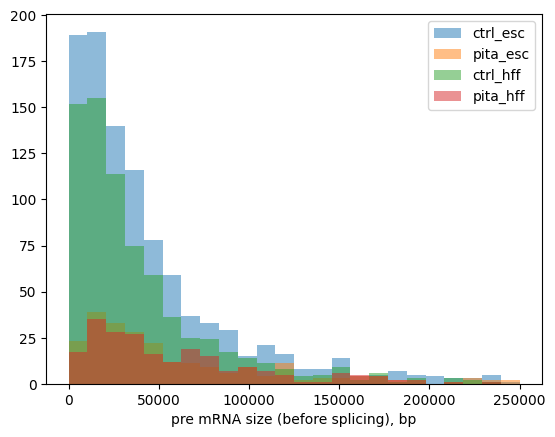

In [15]:
bins  = np.linspace(0,250_000,25)
for k in genesdf:
    #
    plt.hist(genesdf[k]["size"],bins=bins,label=f"{k}",alpha=0.5)

ax = plt.gca()
ax.set_xlabel("pre mRNA size (before splicing), bp")
ax.legend()

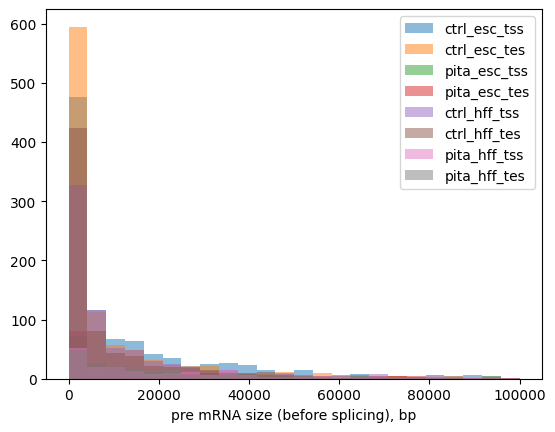

In [18]:
bins  = np.linspace(0,100_000,25)
for k in genesdf:
    # if "pita" in k:
    #     continue
    # #
    plt.hist(gtss[k]["size"],bins=bins,label=f"{k}_tss",alpha=0.5)
    plt.hist(gtes[k]["size"],bins=bins,label=f"{k}_tes",alpha=0.5)

ax = plt.gca()
ax.set_xlabel("pre mRNA size (before splicing), bp")
ax.legend()

In [19]:
# get our coolers ...?
clr_fnames = {
    "esc": "esc_microc.hg38.mapq_30.250.mcool",
    "hff": "hff_microc.hg38.mapq_30.250.mcool",
}

clrs = {}
binsize = 500

for k,f in clr_fnames.items():
    clrs[k] = cooler.Cooler(f"{f}::/resolutions/{binsize}")

In [20]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
# create a view with chromosome arms using chromosome sizes and definition of centromeres
hg38_arms_full = bioframe.make_chromarms(hg38_chromsizes,  hg38_cens)
# # remove "bad" chromosomes and near-empty arms ...
# excluded_arms = ["chr13_p", "chr14_p", "chr15_p", "chr21_p", "chr22_p", "chrM_p", "chrY_p", "chrY_q", "chrX_p", "chrX_q"]
# hg38_arms = hg38_arms_full[~hg38_arms_full["name"].isin(excluded_arms)].reset_index(drop=True)

# can do 1 chromosome (or arm) as well ..
included_arms = hg38_arms_full["name"].to_list()[:44] # all autosomal ones ...
hg38_arms = hg38_arms_full[hg38_arms_full["name"].isin(included_arms)].reset_index(drop=True)

In [21]:
exp_kwargs = dict(view_df=hg38_arms, nproc=8)
fff = lambda xxx: cooltools.expected_cis( clrs[xxx], **exp_kwargs)

with WorkerPool(
        n_jobs = 2,
        daemon = False,
        # start_method = 'spawn',
        start_method = 'fork',
        use_dill = True,
    ) as wpool:
    #
    results = wpool.map( fff, list(clrs) )

# unpack results ...
exps = { k:results[i] for i, k in enumerate(clrs) }

### Try regular pileups ... - we don't do them now

In [22]:
# # stagger regions for pileups into a single giant bedframe to speed up the process ...
# annotated_beddf = []
# for _type, _ggg in zip(["up","down"], [gup, gdown]):
#     for sname, _sites in _ggg.items():
#         __sites = _sites.copy()
#         __sites["sname"] = f"{_type}_{sname}"
#         for _coord in ["start", "end"]:
#             ___sites = __sites.copy()
#             ___sites["coord"] = _coord
#             ___sites = ___sites.eval(f"""
#                 start = {_coord}
#                 end = {_coord}
#             """)
#             annotated_beddf.append(___sites)

# # pd.concat(annotated_beddf, ignore_index=True)
# _annot_bed = pd.concat(annotated_beddf, ignore_index=True)

## Skip regular pileups ...

In [ ]:
# _flank = 100*binsize
# _nproc = 8

# # define job per cooler in this context ...
# ################################################
# def pupjob(dataset_bed, k):
#     """ given k - cooler id, run pileups ... """
#     clr = clrs[k]
#     exp = exps[k]
#     return (k, cooltools.pileup(
#         clr,
#         dataset_bed,
#         view_df=hg38_arms,
#         expected_df=exp,
#         flank=_flank,
#         nproc=_nproc,
#     ))

# ################################################
# with WorkerPool(
#         n_jobs = 2,
#         daemon = False,
#         shared_objects=_annot_bed,
#         start_method = 'fork',
#         use_dill = True,
#     ) as wpool:
#     #
#     results = wpool.map( pupjob, list(clrs), progress_bar=True)

# # unpack results by cooler ...
# stacks = {k:stack for k,stack in results}

# # groups by for unstacking the stacks ...
# ggg = _annot_bed.groupby(by = ["sname","coord","strand"])
# # stacks = {}
# # # results per cooler ...
# # for i,k in enumerate(clrs):
# #     stacks[k] = results[i]

In [ ]:
# # check out individual snippet ...
# plt.imshow(stacks["esc"][:,:,504],norm=Normalize(vmin=1/2,vmax=1+1/2),interpolation="none",cmap="coolwarm")

In [ ]:
# imshow_kwargs = dict(
#     # cmap='RdBu_r',
#     cmap='coolwarm',
#     # norm=LogNorm(vmin=1/1.75,vmax=1.75),
#     norm=Normalize(vmin=1-0.5,vmax=1+0.5),
#     interpolation="none",
# )


# # cell line
# for cell in ["esc","hff"]:
#     # cell = "esc"
    
#     # sss = ['ctrl_esc', 'pita_esc', 'ctrl_hff', 'pita_hff']
#     # clr_names = ["esc","hff"]
#     nrows, ncols = 2, 4
#     fig, axs = plt.subplots(
#         nrows=nrows,
#         ncols=ncols,
#         sharex=False,
#         sharey=True,
#         figsize=(3.5*ncols,1.5*nrows)
#         # figsize=(2.5*ncols,2.5*nrows)
#     )
    
    
#     for i, cond in enumerate(["ctrl", "pita"]):
#         for j, _type in enumerate(["up", "down"]):
#             # now let's try some filtering
#             #######################################
#             # TSS - aka start
#             #######################################
#             ax = axs[j, 2*i]
#             _dd = ggg.get_group((f'{_type}_{cond}_{cell}', 'start', '+'))
#             _idx_plus = _dd[_dd["exonStarts"].str.split(",").apply(check_spacedout) > 2_000].index
#             _dd = ggg.get_group((f'{_type}_{cond}_{cell}', 'end', '-'))
#             _idx_minus = _dd[_dd["exonStarts"].str.split(",").apply(check_spacedout) > 2_000].index
#             # stack 2 strands correctly :
#             _stt = np.concatenate([
#                 stacks[cell][:,:,_idx_plus],
#                 stacks[cell][::-1,::-1,_idx_minus]
#             ], axis=2)
#             _mmm = np.nanmean( _stt, axis=2 )
#             _mmm45 = plot_cpup(_mmm, flip45=True )
#             _ccc = ax.imshow( _mmm45, **imshow_kwargs )
#             ticks_pixels = np.linspace(0, _mmm45.shape[1], 3)
#             # _ccc = ax.imshow( _mmm, **imshow_kwargs )
#             # ticks_pixels = np.linspace(0, _mmm.shape[1], 3)
#             ax.set_xticks(ticks_pixels)
#             ax.set_xticklabels(["","TSS",""])

#             if i == 0:
#                 ax.set_ylabel(f"{_type}: {cell}")
#             if j == 0:
#                 ax.set_xticklabels(["","",""])
#                 ax.set_title(f"{cond}, +:{len(_idx_plus)}, -:{len(_idx_minus)}")
#             #######################################
#             # TES - aka end
#             #######################################
#             ax = axs[j, 2*i+1]       
#             _dd = ggg.get_group((f'{_type}_{cond}_{cell}', 'end', '+'))
#             _idx_plus = _dd[_dd["exonStarts"].str.split(",").apply(check_spacedout) > 2_000].index
#             _dd = ggg.get_group((f'{_type}_{cond}_{cell}', 'start', '-'))
#             _idx_minus = _dd[_dd["exonStarts"].str.split(",").apply(check_spacedout) > 2_000].index
#             # stack 2 strands correctly :
#             _stt = np.concatenate([
#                 stacks[cell][:,:,_idx_plus],
#                 stacks[cell][::-1,::-1,_idx_minus]
#             ], axis=2)
#             _mmm = np.nanmean( _stt, axis=2 )
#             _mmm45 = plot_cpup(_mmm, flip45=True )
#             _ccc = ax.imshow( _mmm45, **imshow_kwargs )
#             ticks_pixels = np.linspace(0, _mmm45.shape[1], 3)
#             # _ccc = ax.imshow( _mmm, **imshow_kwargs )
#             # ticks_pixels = np.linspace(0, _mmm.shape[1], 3)
#             ax.set_xticks(ticks_pixels)
#             ax.set_xticklabels(["","TES",""])

#             if j == 0:
#                 ax.set_title(f"{cond}, +:{len(_idx_plus)}, -:{len(_idx_minus)}")
#                 ax.set_xticklabels(["","",""])

## different ordering of the same panels ...

In [ ]:
# imshow_kwargs = dict(
#     # cmap='RdBu_r',
#     cmap='coolwarm',
#     # norm=LogNorm(vmin=1/1.75,vmax=1.75),
#     norm=Normalize(vmin=1-0.5,vmax=1+0.5),
#     interpolation="none",
# )


# # cell line
# for cell in ["esc","hff"]:
#     # cell = "esc"
    
#     # sss = ['ctrl_esc', 'pita_esc', 'ctrl_hff', 'pita_hff']
#     # clr_names = ["esc","hff"]
#     nrows, ncols = 2, 4
#     fig, axs = plt.subplots(
#         nrows=nrows,
#         ncols=ncols,
#         sharex=False,
#         sharey=True,
#         figsize=(3.5*ncols,1.5*nrows)
#         # figsize=(2.5*ncols,2.5*nrows)
#     )
    
    
#     for i, cond in enumerate(["ctrl", "pita"]):
#         for j, _type in enumerate(["up", "down"]):
#             # now let's try some filtering
#             #######################################
#             # TSS - aka start
#             #######################################
#             ax = axs[i, 2*j]
#             _dd = ggg.get_group((f'{_type}_{cond}_{cell}', 'start', '+'))
#             _idx_plus = _dd[_dd["exonStarts"].str.split(",").apply(check_spacedout) > 2_000].index
#             _dd = ggg.get_group((f'{_type}_{cond}_{cell}', 'end', '-'))
#             _idx_minus = _dd[_dd["exonStarts"].str.split(",").apply(check_spacedout) > 2_000].index
#             # stack 2 strands correctly :
#             _stt = np.concatenate([
#                 stacks[cell][:,:,_idx_plus],
#                 stacks[cell][::-1,::-1,_idx_minus]
#             ], axis=2)
#             _mmm = np.nanmean( _stt, axis=2 )
#             _mmm45 = plot_cpup(_mmm, flip45=True )
#             _ccc = ax.imshow( _mmm45, **imshow_kwargs )
#             ticks_pixels = np.linspace(0, _mmm45.shape[1], 3)
#             # _ccc = ax.imshow( _mmm, **imshow_kwargs )
#             # ticks_pixels = np.linspace(0, _mmm.shape[1], 3)
#             ax.set_xticks(ticks_pixels)
#             ax.set_xticklabels(["","TSS",""])
#             # saving matrices for Ezequiel ...
#             np.savetxt(f"./output/{cell}_{cond}_{_type}_TSS_rotate45.tsv", _mmm45, fmt='%.18e', delimiter='\t')
#             np.savetxt(f"./output/{cell}_{cond}_{_type}_TSS_full.tsv", _mmm, fmt='%.18e', delimiter='\t')

#             if j == 0:
#                 # ax.set_ylabel(f"{cond}, +:{len(_idx_plus)}, -:{len(_idx_minus)}")
#                 ax.set_ylabel(f"{cell}: {cond}")
#                 ax.set_yticklabels([])
#                 # ax.set_ylabel(f"{_type}: {cell}")
#             if i == 0:
#                 ax.set_xticklabels(["","",""])
#                 ax.set_title(f"{_type}")
#                 # ax.set_title(f"{cond}, +:{len(_idx_plus)}, -:{len(_idx_minus)}")
#             #######################################
#             # TES - aka end
#             #######################################
#             ax = axs[i, 2*j+1]       
#             _dd = ggg.get_group((f'{_type}_{cond}_{cell}', 'end', '+'))
#             _idx_plus = _dd[_dd["exonStarts"].str.split(",").apply(check_spacedout) > 2_000].index
#             _dd = ggg.get_group((f'{_type}_{cond}_{cell}', 'start', '-'))
#             _idx_minus = _dd[_dd["exonStarts"].str.split(",").apply(check_spacedout) > 2_000].index
#             # stack 2 strands correctly :
#             _stt = np.concatenate([
#                 stacks[cell][:,:,_idx_plus],
#                 stacks[cell][::-1,::-1,_idx_minus]
#             ], axis=2)
#             _mmm = np.nanmean( _stt, axis=2 )
#             _mmm45 = plot_cpup(_mmm, flip45=True )
#             _ccc = ax.imshow( _mmm45, **imshow_kwargs )
#             ticks_pixels = np.linspace(0, _mmm45.shape[1], 3)
#             # _ccc = ax.imshow( _mmm, **imshow_kwargs )
#             # ticks_pixels = np.linspace(0, _mmm.shape[1], 3)
#             ax.set_xticks(ticks_pixels)
#             ax.set_xticklabels(["","TES",""])
#             # saving matrices for Ezequiel ...
#             np.savetxt(f"./output/{cell}_{cond}_{_type}_TES_rotate45.tsv", _mmm45, fmt='%.18e', delimiter='\t')
#             np.savetxt(f"./output/{cell}_{cond}_{_type}_TES_full.tsv", _mmm, fmt='%.18e', delimiter='\t')

#             if i == 0:
#                 # ax.set_title(f"{cond}, +:{len(_idx_plus)}, -:{len(_idx_minus)}")
#                 ax.set_xticklabels(["","",""])
#                 ax.set_title(f"{_type}")

# Rescaled pileup time
 - no expected needed - use the shifty-one instead ...

In [23]:
# stagger regions for pileups into a single giant bedframe to speed up the process ...
annotated_genedf = []
for _type, _ggg in zip(["tss","tes"], [gtss, gtes]):
    for sname, _sites in _ggg.items():
        __sites = _sites.copy()
        __sites["sname"] = f"{_type}_{sname}"
        annotated_genedf.append(__sites)

# pd.concat(annotated_beddf, ignore_index=True)
_annot_genes = pd.concat(annotated_genedf, ignore_index=True)
_annot_genes["min_space"] = _annot_genes["exonStarts"].str.split(",").apply(check_spacedout)

In [24]:
# # stagger regions for pileups into a single giant bedframe to speed up the process ...
# annotated_genedf = []
# for _type, _ggg in zip(["up","down"], [gup, gdown]):
#     for sname, _sites in _ggg.items():
#         __sites = _sites.copy()
#         __sites["sname"] = f"{_type}_{sname}"
#         annotated_genedf.append(__sites)

# # pd.concat(annotated_beddf, ignore_index=True)
# _annot_genes = pd.concat(annotated_genedf, ignore_index=True)
# _annot_genes["min_space"] = _annot_genes["exonStarts"].str.split(",").apply(check_spacedout)

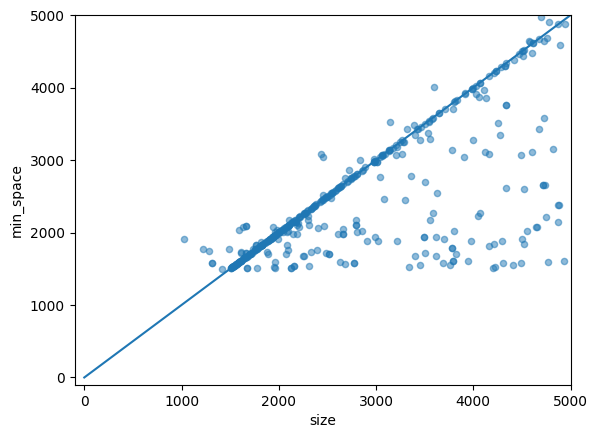

In [25]:
_annot_genes.query("min_space>size").drop(columns=["geneName","refseqId","geneId","geneType","geneDesc","citationCount"])
_annot_genes.query("min_space>1500").plot(x="size",y="min_space",kind="scatter",alpha=0.5)
plt.gca().set_xlim(-100,5000)
plt.gca().set_ylim(-100,5000)
plt.gca().plot([0,5000],[0,5000], )


`get_gene_pup` function listing here ...

```python
    def get_gene_pup(
        sites,
        clr,
        resolution,
        _cols=["chrom","start","end", "strand"],
        _flip_strand=True,
        _nproc=16
    ):
        """
        generate scaled local pile-up for a collection of sites for a given
        cooler (clr) at a given resolution - keeping the padding size equal
        to the interval itself.
        """
        _sites = sites[_cols] \
            .reset_index(drop=True) \
            .rename( dict(zip(_cols,["chrom","start","end","strand"])), axis=1 )
        # create coords - for rescaled genes ...
        cc = cp.CoordCreator(
            _sites,
            resolution=resolution,
            features_format='bed',
            local=True,
            rescale_flank=1.
        )
        # create pileupper object ...
        pu = cp.PileUpper(
            clr,
            cc,
            control = True,
            rescale = True,
            rescale_size = 199,
            flip_negative_strand=_flip_strand,
        )
        print(f"working on a group of {len(_sites)} size ...")
        # pileupsWithControl
        # pileupsByStrandWithControl
        pup = pu.pileupsWithControl(nproc=_nproc)
        # return pup.loc[0,"data"]
        return pup.set_index("group").loc["all","data"]
```

In [26]:
_sites = _annot_genes.query("(min_space>2_500)&(size>8_000)&(size<300_000)").reset_index(drop=True)
print(f"doing rescaled gene pileup for filtered {len(_sites)} genes ...")

# # Using normalization to this local shifty-expected ...
# reslr_shift = {}
# for k, clr in clrs.items():
#     exp = exps[k]
#     reslr_shift[k] = cp.pileup(
#         clr,
#         _sites,
#         features_format='bed',
#         # view_df=hg38_arms,
#         # expected_df=exp,
#         groupby=["sname1", "sname2"],
#         nshifts=10,
#         local=True,  # on-diagonal pileup ...
#         flip_negative_strand=True,
#         rescale=True,
#         rescale_flank=1.0,
#         rescale_size=199,
#         nproc=16,
#     )

# Using normalization to the regulat cis-expected by arm ...
reslr = {}
for k, clr in clrs.items():
    exp = exps[k]
    reslr[k] = cp.pileup(
        clr,
        _sites,
        features_format='bed',
        view_df=hg38_arms,
        expected_df=exp,
        groupby=["sname1", "sname2"],
        local=True,  # on-diagonal pileup ...
        flip_negative_strand=True,
        rescale=True,
        rescale_flank=1.0,
        rescale_size=199,
        nproc=16,
    )

doing rescaled gene pileup for filtered 929 genes ...


INFO:coolpuppy:Rescaling with rescale_flank = 1.0 to 199x199 pixels
INFO:coolpuppy:('chr4_p', 'chr4_p'): 16
INFO:coolpuppy:('chr2_p', 'chr2_p'): 28
INFO:coolpuppy:('chr1_q', 'chr1_q'): 31
INFO:coolpuppy:('chr3_p', 'chr3_p'): 26
INFO:coolpuppy:('chr1_p', 'chr1_p'): 45
INFO:coolpuppy:('chr5_p', 'chr5_p'): 11
INFO:coolpuppy:('chr3_q', 'chr3_q'): 36
INFO:coolpuppy:('chr2_q', 'chr2_q'): 59
INFO:coolpuppy:('chr6_p', 'chr6_p'): 16
INFO:coolpuppy:('chr4_q', 'chr4_q'): 31
INFO:coolpuppy:('chr7_p', 'chr7_p'): 30
INFO:coolpuppy:('chr8_p', 'chr8_p'): 11
INFO:coolpuppy:('chr5_q', 'chr5_q'): 40
INFO:coolpuppy:('chr6_q', 'chr6_q'): 20
INFO:coolpuppy:('chr9_p', 'chr9_p'): 4
INFO:coolpuppy:('chr7_q', 'chr7_q'): 33
INFO:coolpuppy:('chr10_p', 'chr10_p'): 17
INFO:coolpuppy:('chr8_q', 'chr8_q'): 17
INFO:coolpuppy:('chr9_q', 'chr9_q'): 16
INFO:coolpuppy:('chr11_p', 'chr11_p'): 18
INFO:coolpuppy:('chr12_p', 'chr12_p'): 5
INFO:coolpuppy:('chr10_q', 'chr10_q'): 27
INFO:coolpuppy:('chr11_q', 'chr11_q'): 29
INFO

### A way of plotting PileUps

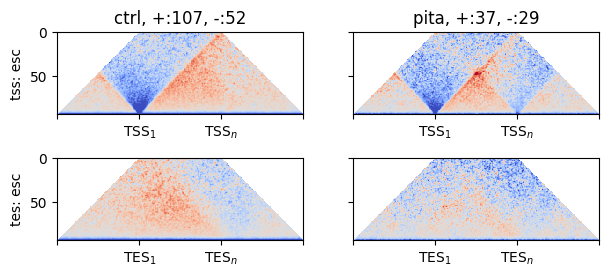

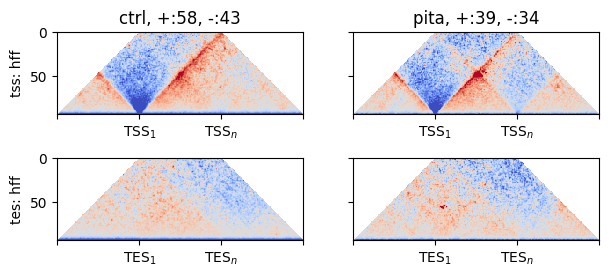

In [44]:
imshow_kwargs = dict(
    # cmap='RdBu_r',
    cmap='coolwarm',
    norm=LogNorm(vmin=1/1.75,vmax=1.75),
    # norm=Normalize(vmin=1-0.5,vmax=1+0.5),
    interpolation="none",
)

nrows, ncols = 2, 2
# cell line
for cell in ["esc","hff"]:
    # cell = "esc"
    fig, axs = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        sharex=False,
        sharey=True,
        figsize=(3.5*ncols,1.5*nrows),
    )
    for i, _type in enumerate(["tss", "tes"]):
        for j, cond in enumerate(["ctrl", "pita"]):
            ax = axs[i, j]
            #
            # deal with matrices ...
            # _mmm = reslr_shift[f"{_type}_{cond}_{cell}"]
            # _mmm = reslr_shift[cell].set_index(["sname1"]).loc[f"{_type}_{cond}_{cell}","data"]
            _mmm = reslr[cell].set_index(["sname1"]).loc[f"{_type}_{cond}_{cell}","data"]
            _mmm45 = plot_cpup(_mmm)
            ax.imshow( _mmm45, **imshow_kwargs )
            # ticks
            ticks_pixels = np.linspace(0, _mmm45.shape[1], 4)
            ax.set_xticks(ticks_pixels)
            if _type =="tss":
                ax.set_xticklabels(["","TSS$_1$","TSS$_n$",""])
            elif _type == "tes":
                ax.set_xticklabels(["","TES$_1$","TES$_n$",""])
            else:
                raise ValueError("type can be tss or tes - nothing else")
            
            if j == 0:
                ax.set_ylabel(f"{_type}: {cell}")

            # count + - sites:
            _s = _annot_genes \
                .groupby(by = "sname") \
                .get_group(f"{_type}_{cond}_{cell}") \
                .query("(min_space>2_500)&(size>8_000)&(size<100_000)")

            _pp = len(_s.query("strand=='+'"))
            _mm = len(_s.query("strand=='-'"))

            if i == 0:
                ax.set_title(f"{cond}, +:{_pp}, -:{_mm}")
                # ax.set_xticklabels(["","",""])
            #
            # for ggplotting by Ezequiel
            np.savetxt(f"./output_scaled/{cell}_{cond}_{_type}_mat45.tsv", _mmm45, delimiter='\t')
    plt.savefig(f"/home/sergpolly/{cell}_tss_tes_pups.png")
    # fig.savefig("")


In [45]:
!readlink -f ./output_scaled/


/home/sergpolly/Desktop/pita-proj/output_scaled


In [31]:
! ls output_scaled

esc_ctrl_down_mat45.tsv  esc_pita_tes_mat45.tsv   hff_ctrl_up_mat45.tsv
esc_ctrl_full_mat45.tsv  esc_pita_tss_mat45.tsv   hff_pita_down_mat45.tsv
esc_ctrl_tes_mat45.tsv	 esc_pita_up_mat45.tsv	  hff_pita_full_mat45.tsv
esc_ctrl_tss_mat45.tsv	 hff_ctrl_down_mat45.tsv  hff_pita_tes_mat45.tsv
esc_ctrl_up_mat45.tsv	 hff_ctrl_full_mat45.tsv  hff_pita_tss_mat45.tsv
esc_pita_down_mat45.tsv  hff_ctrl_tes_mat45.tsv   hff_pita_up_mat45.tsv
esc_pita_full_mat45.tsv  hff_ctrl_tss_mat45.tsv
